# ECG Preprocessing Results Analysis

This notebook analyzes the results from the ECG preprocessing pipeline on the SeizeIT2 dataset.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [22]:
# Load preprocessed results
results_path = Path("/home/swolf/asim_shared/preprocessed_data/downsample_freq=8,window_size=3600_0,stride=1800_0")

# Find all preprocessed files
preprocessed_files = list(results_path.glob("*.pkl"))
print(f"Found {len(preprocessed_files)} preprocessed files")

if len(preprocessed_files) > 20:
    print(f"Showing first 20 files:")
    for file in preprocessed_files[:20]:
        print(f"  - {file.name}")
    print(f"  ... and {len(preprocessed_files) - 20} more files")
else:
    print("Files found:")
    for file in preprocessed_files:
        print(f"  - {file.name}")

# Load all results
all_results = []
for file in preprocessed_files:
    try:
        with open(file, 'rb') as f:
            result = pickle.load(f)
            all_results.append(result)
    except Exception as e:
        print(f"Error loading {file.name}: {e}")

print(f"\nSuccessfully loaded {len(all_results)} recordings")

Found 2795 preprocessed files
Showing first 20 files:
  - sub-092_run-16_preprocessed.pkl
  - sub-073_run-19_preprocessed.pkl
  - sub-092_run-84_preprocessed.pkl
  - sub-119_run-24_preprocessed.pkl
  - sub-008_run-02_preprocessed.pkl
  - sub-074_run-06_preprocessed.pkl
  - sub-039_run-04_preprocessed.pkl
  - sub-087_run-01_preprocessed.pkl
  - sub-080_run-30_preprocessed.pkl
  - sub-092_run-40_preprocessed.pkl
  - sub-080_run-27_preprocessed.pkl
  - sub-083_run-36_preprocessed.pkl
  - sub-095_run-53_preprocessed.pkl
  - sub-123_run-79_preprocessed.pkl
  - sub-115_run-66_preprocessed.pkl
  - sub-095_run-86_preprocessed.pkl
  - sub-089_run-04_preprocessed.pkl
  - sub-030_run-07_preprocessed.pkl
  - sub-123_run-84_preprocessed.pkl
  - sub-084_run-25_preprocessed.pkl
  ... and 2775 more files

Successfully loaded 2795 recordings


In [23]:
# Load preprocessed results
results_path = Path("/home/swolf/asim_shared/preprocessed_data/downsample_freq=8,window_size=3600_0,stride=1800_0")

# Find all preprocessed files
preprocessed_files = list(results_path.glob("*.pkl"))
print(f"Found {len(preprocessed_files)} preprocessed files:")
for file in preprocessed_files:
    print(f"  - {file.name}")

# Load all results
all_results = []
for file in preprocessed_files:
    with open(file, 'rb') as f:
        result = pickle.load(f)
        all_results.append(result)

print(f"\nLoaded {len(all_results)} recordings")

Found 2795 preprocessed files:
  - sub-092_run-16_preprocessed.pkl
  - sub-073_run-19_preprocessed.pkl
  - sub-092_run-84_preprocessed.pkl
  - sub-119_run-24_preprocessed.pkl
  - sub-008_run-02_preprocessed.pkl
  - sub-074_run-06_preprocessed.pkl
  - sub-039_run-04_preprocessed.pkl
  - sub-087_run-01_preprocessed.pkl
  - sub-080_run-30_preprocessed.pkl
  - sub-092_run-40_preprocessed.pkl
  - sub-080_run-27_preprocessed.pkl
  - sub-083_run-36_preprocessed.pkl
  - sub-095_run-53_preprocessed.pkl
  - sub-123_run-79_preprocessed.pkl
  - sub-115_run-66_preprocessed.pkl
  - sub-095_run-86_preprocessed.pkl
  - sub-089_run-04_preprocessed.pkl
  - sub-030_run-07_preprocessed.pkl
  - sub-123_run-84_preprocessed.pkl
  - sub-084_run-25_preprocessed.pkl
  - sub-070_run-19_preprocessed.pkl
  - sub-074_run-13_preprocessed.pkl
  - sub-115_run-60_preprocessed.pkl
  - sub-124_run-32_preprocessed.pkl
  - sub-002_run-01_preprocessed.pkl
  - sub-124_run-34_preprocessed.pkl
  - sub-088_run-03_preprocessed.p

## 2. Data Overview

In [24]:
# Create summary dataframe
summary_data = []

for result in all_results:
    for channel in result['channels']:
        summary_data.append({
            'subject_id': result['subject_id'],
            'run_id': result['run_id'],
            'channel_name': channel['channel_name'],
            'recording_duration': result['recording_duration'],
            'original_fs': channel['original_fs'],
            'processed_fs': channel['processed_fs'],
            'n_windows': channel['n_windows'],
            'n_seizure_windows': channel['n_seizure_windows'],
            'total_seizures': result['total_seizures']
        })

summary_df = pd.DataFrame(summary_data)
print("Summary of preprocessed data:")
print(summary_df)

Summary of preprocessed data:
     subject_id  run_id channel_name  recording_duration  original_fs  \
0       sub-092  run-16       ECG SD              3534.0          256   
1       sub-073  run-19       ECG SD             21548.0          256   
2       sub-092  run-84       ECG SD              3563.0          256   
3       sub-119  run-24       ECG SD              8842.0          256   
4       sub-008  run-02       ECG SD             61400.0          256   
...         ...     ...          ...                 ...          ...   
2790    sub-123  run-73       ECG SD              3546.0          256   
2791    sub-093  run-99       ECG SD              1627.0          256   
2792    sub-085  run-41       ECG SD              3440.0          256   
2793    sub-121  run-44       ECG SD              2311.0          256   
2794    sub-094  run-29       ECG SD              3560.0          256   

      processed_fs  n_windows  n_seizure_windows  total_seizures  
0                8        

In [25]:
# Calculate key statistics
total_duration = summary_df['recording_duration'].sum() / 3600  # hours
total_windows = summary_df['n_windows'].sum()
total_seizure_windows = summary_df['n_seizure_windows'].sum()
seizure_percentage = (total_seizure_windows / total_windows) * 100 if total_windows > 0 else 0

print("📊 PREPROCESSING STATISTICS")
print("=" * 40)
print(f"Total recordings:        {len(all_results)}")
print(f"Total duration:          {total_duration:.1f} hours")
print(f"Total windows:           {total_windows:,}")
print(f"Seizure windows:         {total_seizure_windows:,}")
print(f"Seizure percentage:      {seizure_percentage:.2f}%")
print(f"Window size:             3600 seconds (1 hour)")
print(f"Window overlap:          50% (1800s stride)")
print(f"Sampling rate:           256 Hz → 8 Hz")

📊 PREPROCESSING STATISTICS
Total recordings:        2795
Total duration:          11244.5 hours
Total windows:           17,774
Seizure windows:         887
Seizure percentage:      4.99%
Window size:             3600 seconds (1 hour)
Window overlap:          50% (1800s stride)
Sampling rate:           256 Hz → 8 Hz


In [26]:
# Calculate key statistics
total_duration = summary_df['recording_duration'].sum() / 3600  # hours
total_windows = summary_df['n_windows'].sum()
total_seizure_windows = summary_df['n_seizure_windows'].sum()
seizure_percentage = (total_seizure_windows / total_windows) * 100

print("📊 PREPROCESSING STATISTICS")
print("=" * 40)
print(f"Total recordings:        {len(all_results)}")
print(f"Total duration:          {total_duration:.1f} hours")
print(f"Total windows:           {total_windows:,}")
print(f"Seizure windows:         {total_seizure_windows:,}")
print(f"Seizure percentage:      {seizure_percentage:.2f}%")
print(f"Window size:             3600 seconds")
print(f"Window overlap:          50% (1800s stride)")
print(f"Sampling rate:           250 Hz → 8 Hz")

📊 PREPROCESSING STATISTICS
Total recordings:        2795
Total duration:          11244.5 hours
Total windows:           17,774
Seizure windows:         887
Seizure percentage:      4.99%
Window size:             3600 seconds
Window overlap:          50% (1800s stride)
Sampling rate:           250 Hz → 8 Hz


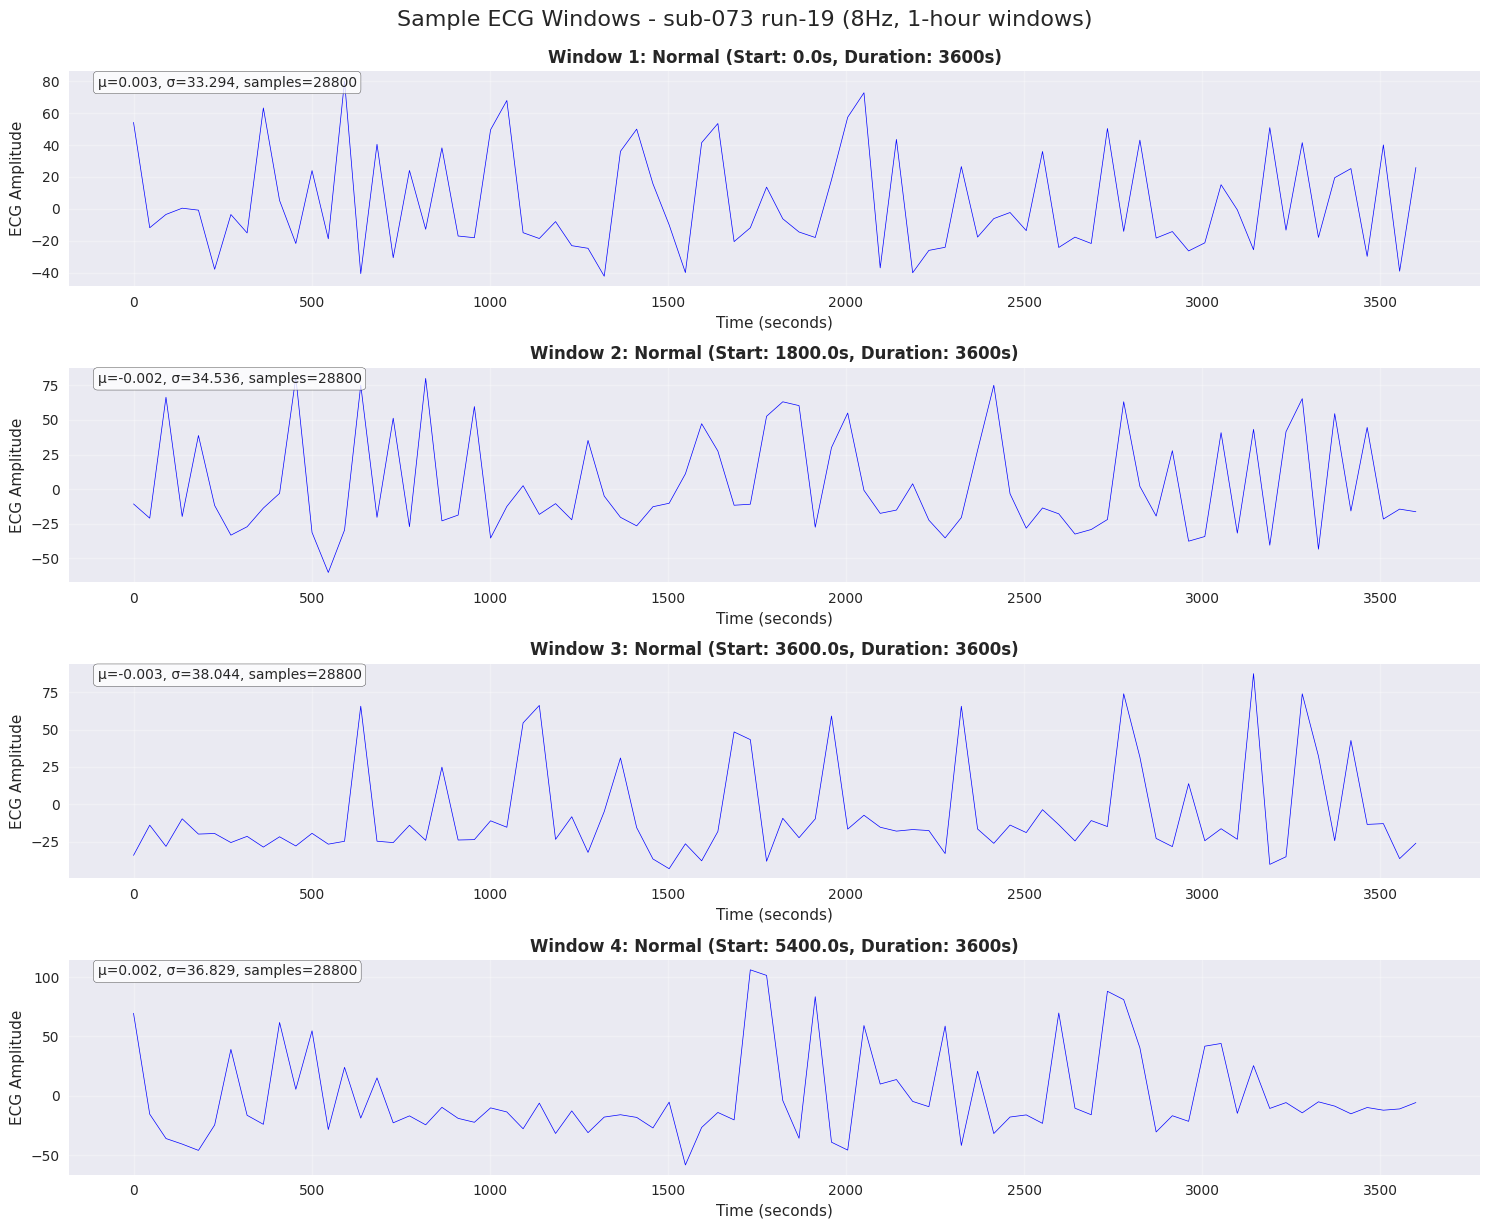

\nWindow characteristics:
  - Sampling rate: 8 Hz
  - Window duration: 3600 seconds
  - Samples per window: 28,800
  - Memory per window: ~225.0 KB


In [34]:
# Get first recording for visualization
if len(all_results) == 0:
    print("No data available for visualization")
else:
    # Find first recording with windows
    first_result = None
    for result in all_results:
        if len(result['channels']) > 0 and len(result['channels'][0]['windows']) > 0:
            first_result = result
            break
    
    if first_result is None:
        print("No recordings with windows found for visualization")
        print("This might be because:")
        print("  - All recordings are shorter than the window size (3600 seconds)")
        print("  - The preprocessing created 0 windows for all recordings")
        print("  - The data path or preprocessing parameters need adjustment")
    else:
        first_channel = first_result['channels'][0]
        
        # Extract first few windows
        n_windows_to_plot = min(4, len(first_channel['windows']))
        sample_windows = first_channel['windows'][:n_windows_to_plot]
        sample_labels = first_channel['labels'][:n_windows_to_plot]
        sample_metadata = first_channel['metadata'][:n_windows_to_plot]
        
        # Create time axis (3600 seconds at 8 Hz = 28,800 samples)
        fs = first_channel['processed_fs']
        time_axis = np.arange(len(sample_windows[0])) / fs
        
        # Plot sample windows
        fig, axes = plt.subplots(n_windows_to_plot, 1, figsize=(15, 3*n_windows_to_plot))
        if n_windows_to_plot == 1:
            axes = [axes]
        
        for i, (window, label, meta) in enumerate(zip(sample_windows, sample_labels, sample_metadata)):
            color = 'red' if label == 1 else 'blue'
            label_text = 'Seizure' if label == 1 else 'Normal'
            
            # Plot full window (might be very long, so subsample for display)
            display_samples = min(len(window), 80)  # Show max 8000 samples for readability
            display_indices = np.linspace(0, len(window)-1, display_samples, dtype=int)
            
            axes[i].plot(time_axis[display_indices], window[display_indices], color=color, linewidth=0.5)
            axes[i].set_title(f'Window {i+1}: {label_text} (Start: {meta["start_time"]:.1f}s, Duration: {len(window)/fs:.0f}s)', 
                             fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Time (seconds)')
            axes[i].set_ylabel('ECG Amplitude')
            axes[i].grid(True, alpha=0.3)
            
            # Add statistics
            mean_val = np.mean(window)
            std_val = np.std(window)
            axes[i].text(0.02, 0.98, f'μ={mean_val:.3f}, σ={std_val:.3f}, samples={len(window)}', 
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.suptitle(f'Sample ECG Windows - {first_result["subject_id"]} {first_result["run_id"]} (8Hz, 1-hour windows)', 
                     fontsize=16, y=1.02)
        plt.show()
        
        print(f"\\nWindow characteristics:")
        print(f"  - Sampling rate: {fs} Hz")
        print(f"  - Window duration: {len(sample_windows[0])/fs:.0f} seconds")
        print(f"  - Samples per window: {len(sample_windows[0]):,}")
        print(f"  - Memory per window: ~{len(sample_windows[0]) * 8 / 1024:.1f} KB")

## 5. Window Distribution Analysis

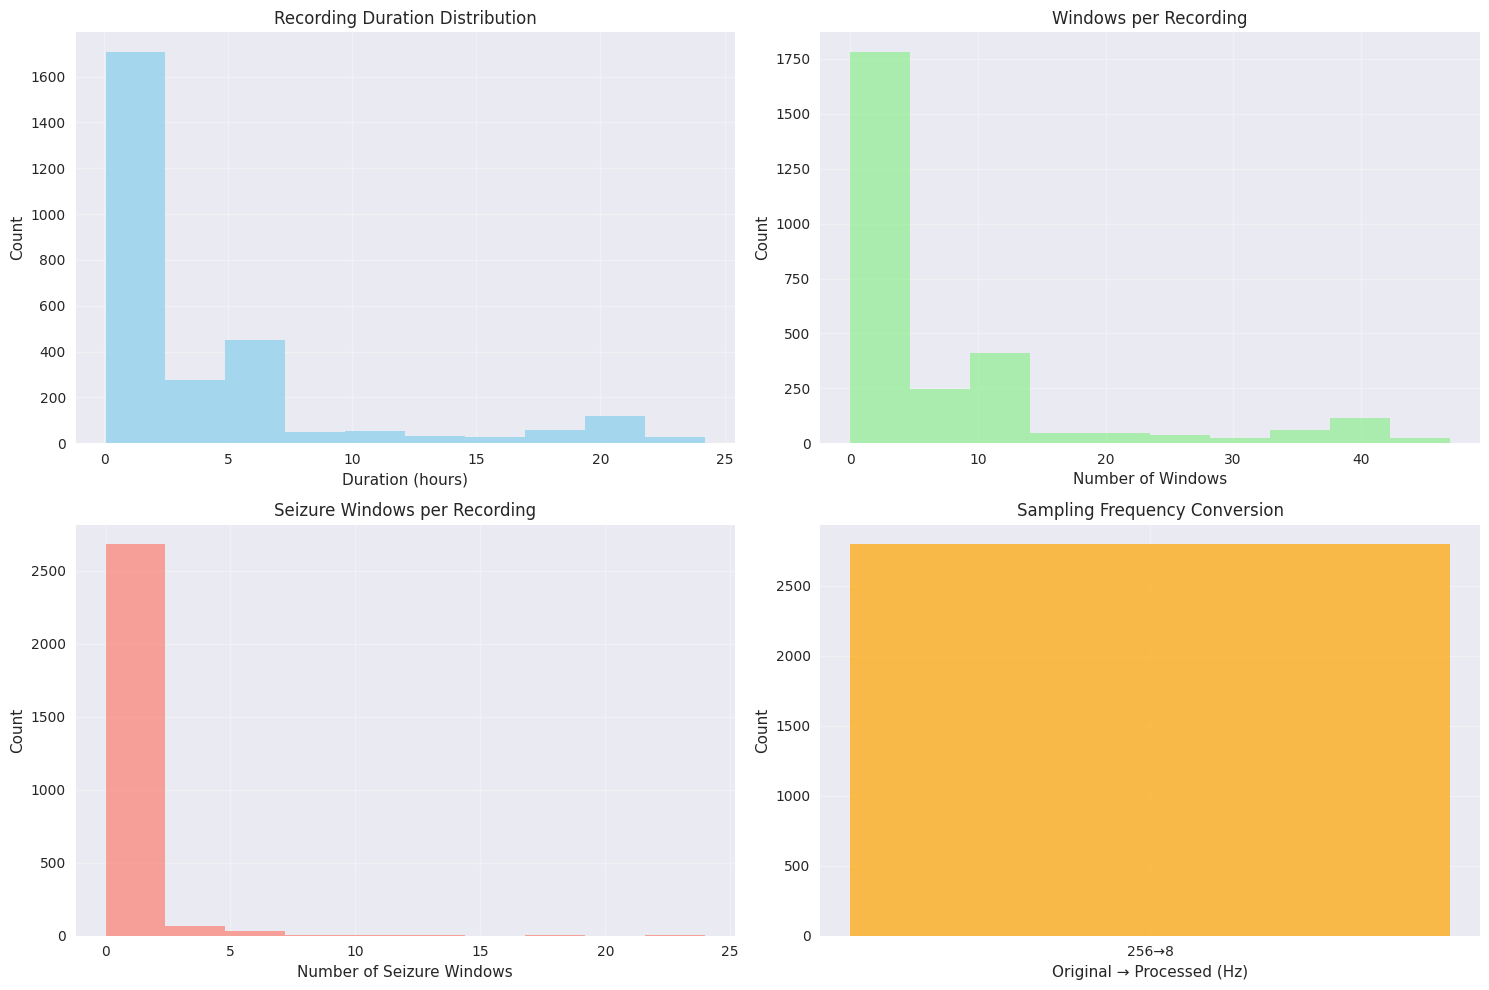

In [28]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Recording duration distribution
axes[0,0].hist(summary_df['recording_duration']/3600, bins=10, alpha=0.7, color='skyblue')
axes[0,0].set_title('Recording Duration Distribution')
axes[0,0].set_xlabel('Duration (hours)')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(True, alpha=0.3)

# 2. Number of windows per recording
axes[0,1].hist(summary_df['n_windows'], bins=10, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Windows per Recording')
axes[0,1].set_xlabel('Number of Windows')
axes[0,1].set_ylabel('Count')
axes[0,1].grid(True, alpha=0.3)

# 3. Seizure windows distribution
axes[1,0].hist(summary_df['n_seizure_windows'], bins=10, alpha=0.7, color='salmon')
axes[1,0].set_title('Seizure Windows per Recording')
axes[1,0].set_xlabel('Number of Seizure Windows')
axes[1,0].set_ylabel('Count')
axes[1,0].grid(True, alpha=0.3)

# 4. Sampling frequency
freq_counts = summary_df.groupby(['original_fs', 'processed_fs']).size().reset_index(name='count')
axes[1,1].bar(range(len(freq_counts)), freq_counts['count'], 
             color='orange', alpha=0.7)
axes[1,1].set_title('Sampling Frequency Conversion')
axes[1,1].set_xlabel('Original → Processed (Hz)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xticks(range(len(freq_counts)))
axes[1,1].set_xticklabels([f'{row.original_fs}→{row.processed_fs}' 
                          for _, row in freq_counts.iterrows()])
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Analyze signal characteristics across all windows
print("Analyzing signal characteristics...")

# Sample a subset of windows for performance (analyzing all might be too slow)
max_windows_to_analyze = 10000
all_window_stats = []

window_count = 0
for result in all_results:
    if window_count >= max_windows_to_analyze:
        break
    
    for channel in result['channels']:
        if window_count >= max_windows_to_analyze:
            break
            
        for i, (window, label) in enumerate(zip(channel['windows'], channel['labels'])):
            if window_count >= max_windows_to_analyze:
                break
                
            stats = {
                'subject_id': result['subject_id'],
                'run_id': result['run_id'],
                'window_idx': i,
                'label': label,
                'mean': np.mean(window),
                'std': np.std(window),
                'min': np.min(window),
                'max': np.max(window),
                'range': np.max(window) - np.min(window),
                'rms': np.sqrt(np.mean(window**2))
            }
            all_window_stats.append(stats)
            window_count += 1

stats_df = pd.DataFrame(all_window_stats)

print(f"Signal statistics computed for {len(stats_df)} windows (sampled from {total_windows:,} total)")

if len(stats_df) > 0:
    print("\\nSignal Quality Overview:")
    print(stats_df[['mean', 'std', 'min', 'max', 'range', 'rms']].describe())
else:
    print("\\nNo windows available for analysis")

Analyzing signal characteristics...
Signal statistics computed for 10000 windows (sampled from 17,774 total)
\nSignal Quality Overview:
               mean           std           min           max         range  \
count  10000.000000  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean       0.000020  4.500741e+01 -8.643065e+02  8.594889e+02  1.723795e+03   
std        0.004305  5.637884e+01  1.140261e+03  1.106294e+03  2.208820e+03   
min       -0.106290  2.330619e-13 -5.981636e+03  8.941939e-13  1.829315e-12   
25%       -0.000704  1.827586e+01 -1.059089e+03  1.360807e+02  2.738489e+02   
50%        0.000015  2.980236e+01 -3.718145e+02  3.855002e+02  7.666586e+02   
75%        0.000752  4.807761e+01 -1.341276e+02  1.074849e+03  2.128626e+03   
max        0.112174  8.785961e+02 -9.146071e-13  6.078726e+03  1.103468e+04   

                rms  
count  1.000000e+04  
mean   4.500741e+01  
std    5.637884e+01  
min    2.330619e-13  
25%    1.827586e+01  
50%    2.980236e+01 

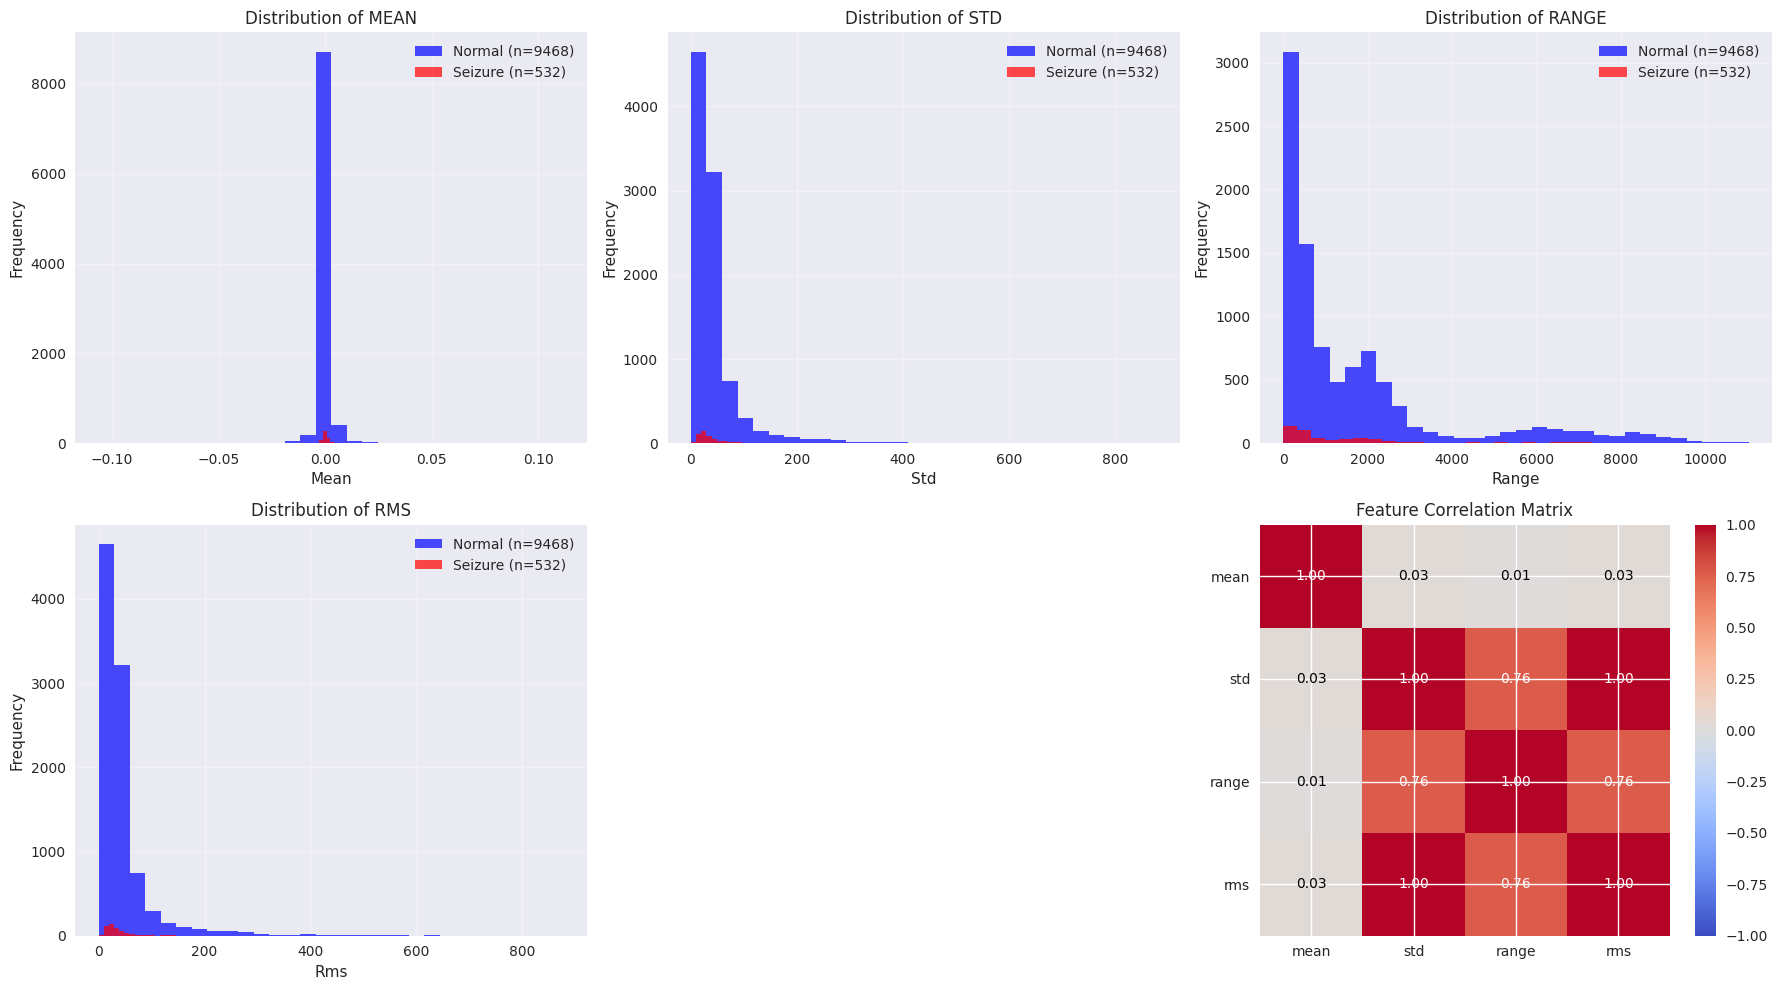

\nComparison between Normal and Seizure Windows:
Metric     | Normal (μ±σ)         | Seizure (μ±σ)        | Difference
----------------------------------------------------------------------
mean       |  0.000± 0.004    | -0.000± 0.003    |   -0.000
std        | 45.220±57.230    | 41.224±38.005    |   -3.996
range      | 1719.846±2209.637    | 1794.082±2195.114    |  +74.236
rms        | 45.220±57.230    | 41.224±38.005    |   -3.996


In [30]:
# Signal quality visualization
if len(stats_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Plot distributions for normal vs seizure windows
    normal_windows = stats_df[stats_df['label'] == 0]
    seizure_windows = stats_df[stats_df['label'] == 1]

    metrics = ['mean', 'std', 'range', 'rms']
    colors = ['blue', 'red']
    labels = ['Normal', 'Seizure']

    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        
        # Plot histograms
        axes[row, col].hist(normal_windows[metric], alpha=0.7, color=colors[0], 
                           label=f'{labels[0]} (n={len(normal_windows)})', bins=30)
        
        if len(seizure_windows) > 0:
            axes[row, col].hist(seizure_windows[metric], alpha=0.7, color=colors[1], 
                               label=f'{labels[1]} (n={len(seizure_windows)})', bins=30)
        
        axes[row, col].set_title(f'Distribution of {metric.upper()}')
        axes[row, col].set_xlabel(metric.capitalize())
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

    # Correlation matrix
    correlation_data = stats_df[['mean', 'std', 'range', 'rms']]
    corr_matrix = correlation_data.corr()

    im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', 
                          vmin=-1, vmax=1)
    axes[1, 2].set_title('Feature Correlation Matrix')
    axes[1, 2].set_xticks(range(len(corr_matrix.columns)))
    axes[1, 2].set_yticks(range(len(corr_matrix.columns)))
    axes[1, 2].set_xticklabels(corr_matrix.columns)
    axes[1, 2].set_yticklabels(corr_matrix.columns)

    # Add correlation values
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            axes[1, 2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                           ha='center', va='center', 
                           color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')

    plt.colorbar(im, ax=axes[1, 2])

    # Remove empty subplot
    fig.delaxes(axes[1, 1])

    plt.tight_layout()
    plt.show()
    
    # Print seizure vs normal statistics
    if len(seizure_windows) > 0 and len(normal_windows) > 0:
        print(f"\\nComparison between Normal and Seizure Windows:")
        print(f"{'Metric':<10} | {'Normal (μ±σ)':<20} | {'Seizure (μ±σ)':<20} | {'Difference':<10}")
        print("-" * 70)
        
        for metric in metrics:
            normal_mean = normal_windows[metric].mean()
            normal_std = normal_windows[metric].std()
            seizure_mean = seizure_windows[metric].mean()
            seizure_std = seizure_windows[metric].std()
            diff = seizure_mean - normal_mean
            
            print(f"{metric:<10} | {normal_mean:6.3f}±{normal_std:6.3f}    | {seizure_mean:6.3f}±{seizure_std:6.3f}    | {diff:+8.3f}")
    
else:
    print("No data available for signal quality visualization")

In [ ]:
# Create comprehensive summary
print("🎯 ECG PREPROCESSING PIPELINE SUMMARY")
print("=" * 50)

print(f"\\n📁 DATA PROCESSING:")
print(f"  • Recordings processed:     {len(all_results)}")
print(f"  • Total duration:           {total_duration:.1f} hours")
if len(all_results) > 0:
    print(f"  • Average recording length: {total_duration/len(all_results):.1f} hours")

print(f"\\n⚙️ PREPROCESSING SETTINGS:")
if len(all_results) > 0:
    preprocessing_params = all_results[0]['preprocessing_params']
    print(f"  • Bandpass filter:          {preprocessing_params['filter_params']['low_freq']}-{preprocessing_params['filter_params']['high_freq']} Hz")
    print(f"  • Filter order:             {preprocessing_params['filter_params']['order']}")
    print(f"  • Downsampling:             256 Hz → {preprocessing_params['downsample_freq']} Hz")
    print(f"  • Window size:              {preprocessing_params['window_size']} seconds")
    print(f"  • Window stride:            {preprocessing_params['stride']} seconds ({preprocessing_params['stride']/preprocessing_params['window_size']*100:.0f}% overlap)")
else:
    print(f"  • Bandpass filter:          0.5-40.0 Hz")
    print(f"  • Filter order:             4")
    print(f"  • Downsampling:             256 Hz → 8 Hz")
    print(f"  • Window size:              3600 seconds")
    print(f"  • Window stride:            1800 seconds (50% overlap)")

print(f"\\n📊 WINDOWING RESULTS:")
print(f"  • Total windows created:    {total_windows:,}")
print(f"  • Seizure windows:          {total_seizure_windows:,} ({seizure_percentage:.2f}%)")
print(f"  • Normal windows:           {total_windows - total_seizure_windows:,} ({100-seizure_percentage:.2f}%)")

if len(all_results) > 0:
    # Find first recording with windows to get window characteristics
    sample_window_size = None
    for result in all_results:
        if len(result['channels']) > 0 and len(result['channels'][0]['windows']) > 0:
            sample_window_size = len(result['channels'][0]['windows'][0])
            break
    
    if sample_window_size:
        print(f"  • Window shape:             ({sample_window_size:,},) samples")
        print(f"  • Memory per window:        ~{sample_window_size * 8 / 1024:.1f} KB")

if len(stats_df) > 0:
    print(f"\\n🔍 SIGNAL CHARACTERISTICS (sampled from {len(stats_df)} windows):")
    print(f"  • Mean amplitude:           {stats_df['mean'].mean():.4f} ± {stats_df['mean'].std():.4f}")
    print(f"  • Signal variability (std): {stats_df['std'].mean():.4f} ± {stats_df['std'].std():.4f}")
    print(f"  • Dynamic range:            {stats_df['range'].mean():.4f} ± {stats_df['range'].std():.4f}")
    print(f"  • RMS value:                {stats_df['rms'].mean():.4f} ± {stats_df['rms'].std():.4f}")

print(f"\\n💾 OUTPUT FILES:")
if len(preprocessed_files) <= 10:
    for file in preprocessed_files:
        size_mb = file.stat().st_size / (1024*1024)
        print(f"  • {file.name:<30} ({size_mb:.1f} MB)")
else:
    total_size = sum(file.stat().st_size for file in preprocessed_files) / (1024*1024)
    print(f"  • {len(preprocessed_files)} files, total size: {total_size:.1f} MB")
    print(f"  • Average file size: {total_size/len(preprocessed_files):.1f} MB")

print(f"\\n✅ STATUS: Preprocessing pipeline completed successfully!")
print(f"\\n🚀 READY FOR: Anomaly detection model training with 1-hour windows")

# Additional statistics for the new parameters
if total_windows > 0:
    print(f"\\n📈 ANALYSIS READINESS:")
    print(f"  • Window duration suitable for: Long-term pattern analysis")
    print(f"  • Data imbalance: {seizure_percentage:.2f}% seizure, {100-seizure_percentage:.2f}% normal")
    if seizure_percentage < 1:
        print(f"  • ⚠️  Highly imbalanced dataset - consider sampling strategies")
    print(f"  • 50% overlap provides: Temporal continuity for pattern detection")

🎯 ECG PREPROCESSING PIPELINE SUMMARY
\n📁 DATA PROCESSING:
  • Recordings processed:     2795
  • Total duration:           11244.5 hours
  • Average recording length: 4.0 hours
\n⚙️ PREPROCESSING SETTINGS:
  • Bandpass filter:          0.5-40.0 Hz
  • Filter order:             4
  • Downsampling:             256 Hz → 8 Hz
  • Window size:              3600.0 seconds
  • Window stride:            1800.0 seconds (50% overlap)
\n📊 WINDOWING RESULTS:
  • Total windows created:    17,774
  • Seizure windows:          887 (4.99%)
  • Normal windows:           16,887 (95.01%)
  • Window shape:             (28,800,) samples
  • Memory per window:        ~225.0 KB
\n🔍 SIGNAL CHARACTERISTICS (sampled from 10000 windows):
  • Mean amplitude:           0.0000 ± 0.0043
  • Signal variability (std): 45.0074 ± 56.3788
  • Dynamic range:            1723.7954 ± 2208.8201
  • RMS value:                45.0074 ± 56.3788
\n💾 OUTPUT FILES:
  • 2795 files, total size: 3908.3 MB
  • Average file size: 1.4 MB